# K-Means Clustering on Online Retail Store

### This dataset  is available on the link below:
https://archive.ics.uci.edu/ml/datasets/Online+Retail

# Pre-processing Data

### Adding Imports

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.cm as cm
from scipy.spatial.distance import cdist
from matplotlib.colors import ListedColormap


%matplotlib inline

### Loading the Online Retail dataset from an Excel file hosted locally

In [44]:
def load_data(filename):
    return pd.read_excel(filename,  sheet_name = "Online Retail", engine = 'openpyxl')

filename = "Online_Retail.xlsx"
# url= "https://github.com/hindupurv/advance_data_science_assignment1/blob/main/Online%20Retail.xlsx"
df = load_data(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


<AxesSubplot: xlabel='Percent missing', ylabel='Feature'>

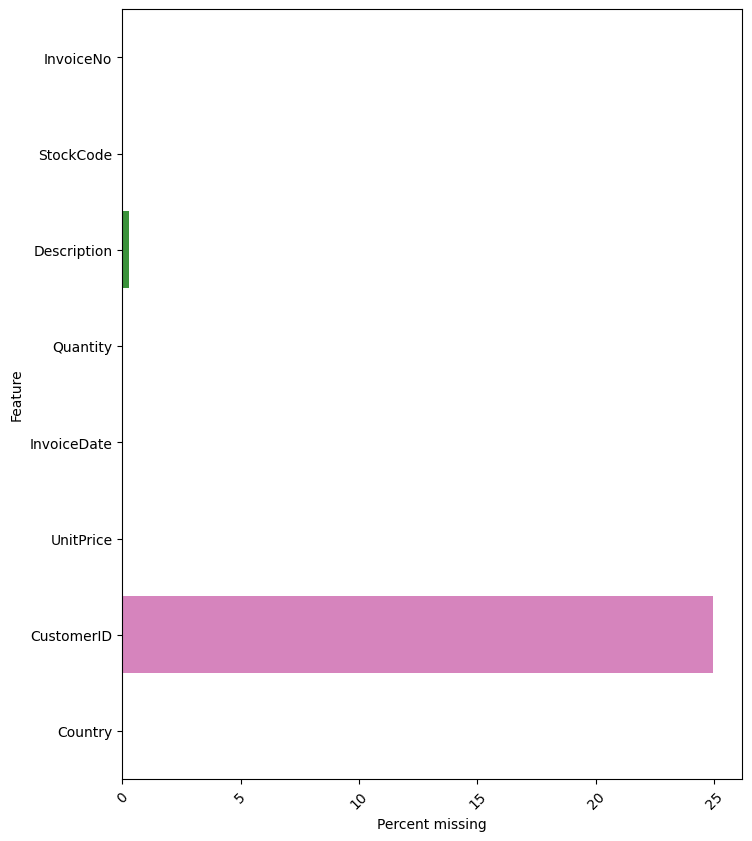

In [48]:
'''Calculate percentage null values for each column or feature'''

null_vals = df.isnull().sum()/len(df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,10))
plt.xticks(rotation=45)
sns.barplot(x = "Percent missing",y ="Feature",data = null_vals,orient = "h")

In [49]:
'''Drop rows with any null values'''

df1 = df.dropna(subset = ["CustomerID","Description"])
print(df.shape,"diff", df1.shape)

(541909, 8) diff (406829, 8)


In [50]:
'''Drop duplicated rows'''

df2 = df1.drop_duplicates()
print(df2.shape)
df2.head(2)

(401604, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [51]:
'''Select columns you need'''

df3 = df2 [['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]
print(df3.shape)
df3.head(2)

(401604, 5)


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55
1,17850.0,2010-12-01 08:26:00,536365,6,3.39


In [52]:
'''Create a total price column by multiplying quantity with unit price'''

df3['TotalPrice'] = df3['Quantity'] * df3['UnitPrice']
print(df3.shape)
df3.head(2)

# feature engineering - added more columns in the available data

(401604, 6)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19492\3978668798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['TotalPrice'] = df3['Quantity'] * df3['UnitPrice']


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [53]:
'''Print out earliest and latest dates in the data'''

print('Min:{}; Max:{}'.format(df3["InvoiceDate"].min(), df3["InvoiceDate"].max()))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:50:00


In [57]:
'''Create a reference point for the analysis'''

current_date = dt.datetime(2023,12,10)
current_date

datetime.datetime(2023, 12, 10, 0, 0)

In [58]:
'''Calculate the aggregates" recency, frequency and, monetary. Recency tells you how many days since
last transaction for each customer, frequency tells you how frequently does a customer shop and,
monetary tells you the total shopping spending for each customer'''

df4 = df3.groupby(['CustomerID']).agg({ 'InvoiceDate': lambda x: (current_date - x.max()).days, 'InvoiceNo': 'count',
'TotalPrice': 'sum'})
df4.rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency','TotalPrice': 'Monetary'}, inplace=True)
print(df4.shape)
df4.head(3)

(4372, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,4708,2,0.00
12347.0,4385,182,4310.00
12348.0,4458,31,1797.24


In [59]:
'''Remove rows with any zero values. This is to facilitate downstream pre-processing and avoid NaNs'''

df5 = df4[(df4 > 0).all(1)]
print(df5.shape)

(4322, 3)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19492\1653390121.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5['Recency'])  #deprecated


<AxesSubplot: xlabel='Recency', ylabel='Count'>

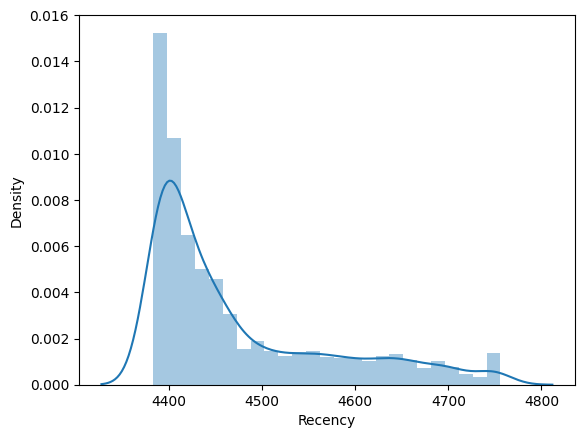

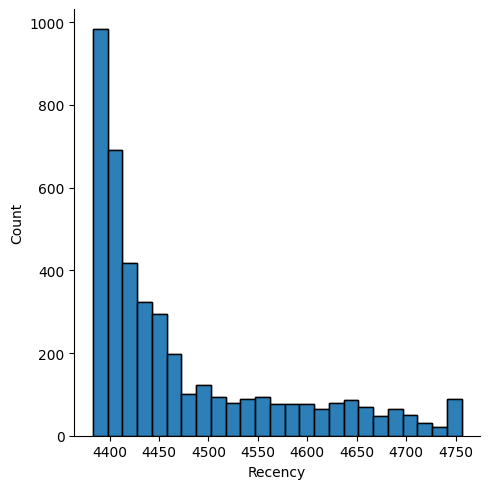

In [60]:
'''Are the data dimensions skewed?'''

sns.distplot(df5['Recency'])  #deprecated 
sns.displot(df5['Recency'])
sns.histplot(df5['Recency'])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19492\590665190.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5['Frequency'])


<AxesSubplot: xlabel='Frequency', ylabel='Density'>

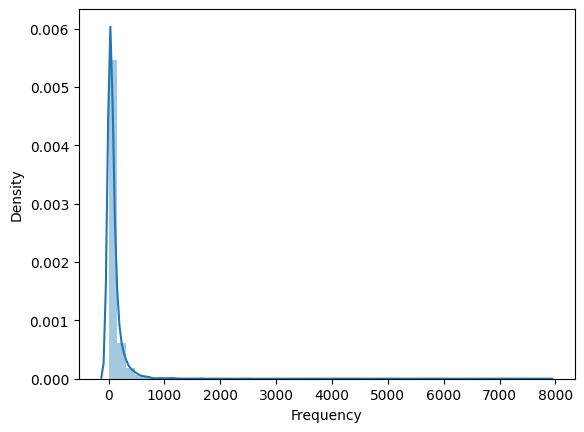

In [61]:
sns.distplot(df5['Frequency'])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19492\1026065201.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5['Monetary'])


<AxesSubplot: xlabel='Monetary', ylabel='Density'>

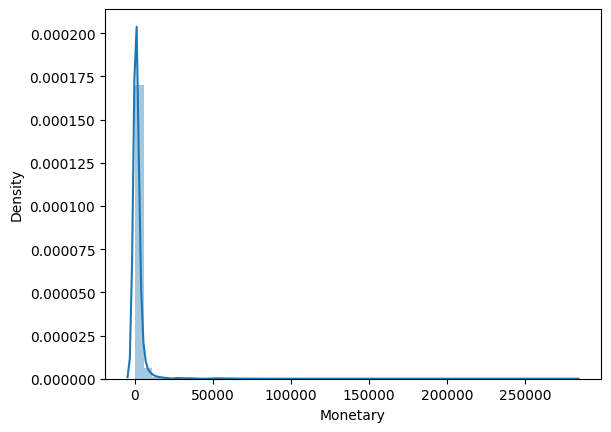

In [62]:
sns.distplot(df5['Monetary'])

In [63]:
'''Looks like the data is skewed. Maybe monetary is not, but the other two definitely are skewed. We log
transform the data to remove the skew. Add a constant to offset any negative values. '''

df6 = (np.log(df5 + 1))
print(df6.shape)
df6.head(3)

(4322, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12347.0,8.386173,5.209486,8.368925
12348.0,8.402680,3.465736,7.494564
12349.0,8.389814,4.304065,7.472245


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19492\4109149228.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df6['Recency'])


<AxesSubplot: xlabel='Recency', ylabel='Density'>

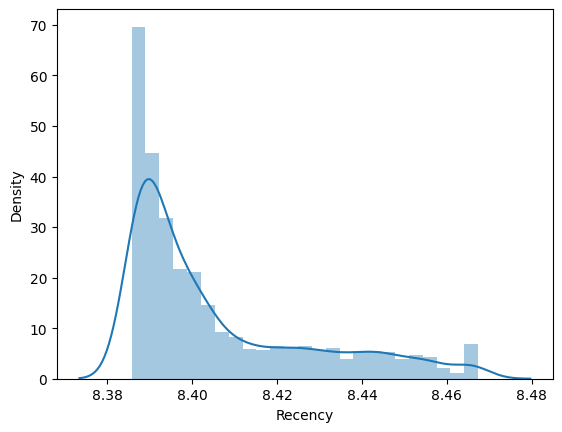

In [64]:
'''Has log transfors made any difference?'''

sns.distplot(df6['Recency'])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19492\2722544356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df6['Frequency'])


<AxesSubplot: xlabel='Frequency', ylabel='Density'>

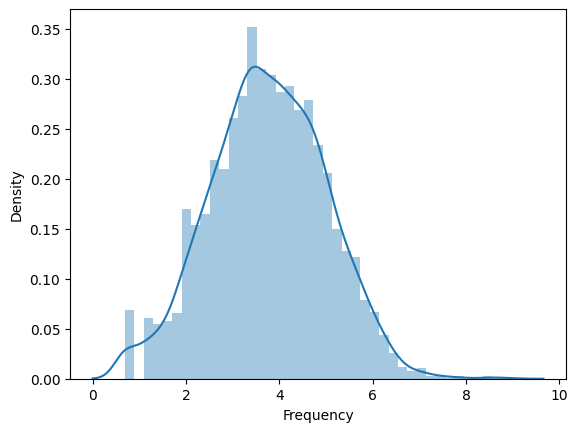

In [65]:
'''Has log transfors made any difference?'''

sns.distplot(df6['Frequency'])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19492\2255834918.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df6['Monetary'])


<AxesSubplot: xlabel='Monetary', ylabel='Density'>

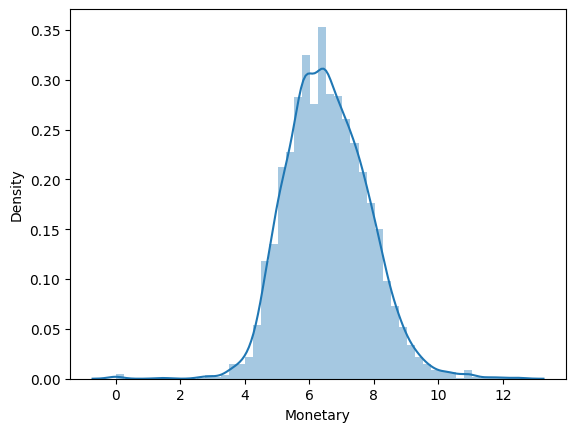

In [66]:
'''Has log transfors made any difference?'''

sns.distplot(df6['Monetary'])

In [78]:
'''Do scaling to make sure all dimensions have equal mean and variance'''
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
scaler.fit(df6)
df7 = pd.DataFrame(scaler.transform(df6))
df7.columns = df6.columns
df7.describe()

,Recency,Frequency,Monetary
count,4.322000e+03,4.322000e+03,4.322000e+03
mean,5.880823e-14,5.056627e-17,-9.067763e-18
std,1.000116e+00,1.000116e+00,1.000116e+00
min,-9.173510e-01,-2.479228e+00,-5.190991e+00
25%,-7.506940e-01,-6.596716e-01,-6.733421e-01
50%,-4.088696e-01,4.572291e-04,-6.046579e-02
75%,5.004868e-01,6.985821e-01,6.594114e-01
max,2.818175e+00,4.205135e+00,4.732577e+00


# K-means clustering

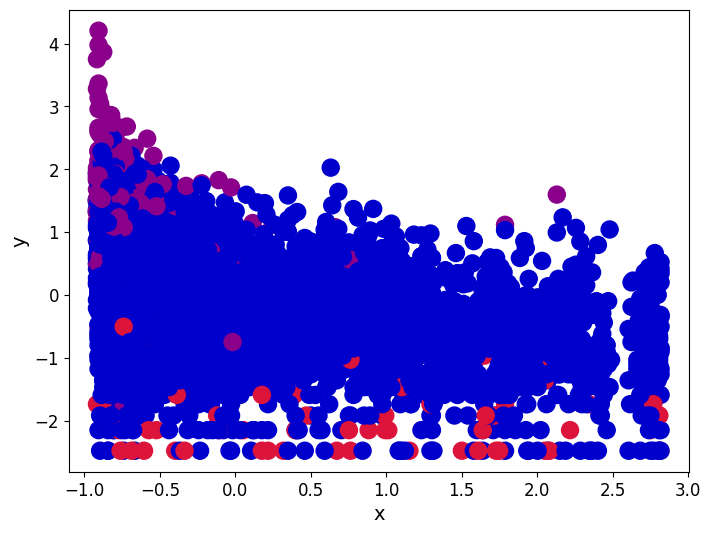

In [133]:
customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x=df['Recency'], y=df['Frequency'], s=150,
            c=df['Monetary'].astype('category'), 
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Creating Clusters

In [134]:
def initiate_centroids(k, dset):
    '''
    Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    '''
    centroids = dset.sample(k)
    return centroids

def rsserr(a,b):
    '''
    Calculate the root of sum of squared errors. 
    a and b are numpy arrays
    '''
    return np.square(np.sum((a-b)**2)) 

np.random.seed(42)
k=3
df = df7
centroids = initiate_centroids(k, df)
centroids

,Recency,Frequency,Monetary,centroid,error
1073,-0.377921,-0.906489,0.213990,0,0.433979
856,-0.813119,-0.121005,-0.104472,0,0.211702
1222,1.103491,0.037201,-0.021986,2,2.831111


# Determining Errors

In [135]:
for i, centroid in enumerate(range(centroids.shape[0])):
    err = rsserr(centroids.iloc[centroid,:], df.iloc[36,:])
    print('Error for centroid {0}: {1:.2f}'.format(i, err))

Error for centroid 0: 7.64
Error for centroid 1: 4.89
Error for centroid 2: 81.23


In [136]:
def centroid_assignation(dset, centroids):
    '''
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid. 
    - dset - pandas dataframe with observations
    - centroids - pa das dataframe with centroids
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs,:])
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

assignation, assign_errors = centroid_assignation(df, centroids)

In [137]:
df['centroid'], df['error'] = centroid_assignation(df, centroids)
df.head()

,Recency,Frequency,Monetary,centroid,error
0,-0.896486,1.171002,1.431403,1,25.390872
1,-0.141341,-0.238345,0.739514,0,20.579557
2,-0.729905,0.439216,0.721853,1,4.048376
3,2.208266,-0.703370,-0.589281,2,87.848720
4,-0.543223,0.649584,0.620128,1,4.931950


# Scatterplot showing clusters 

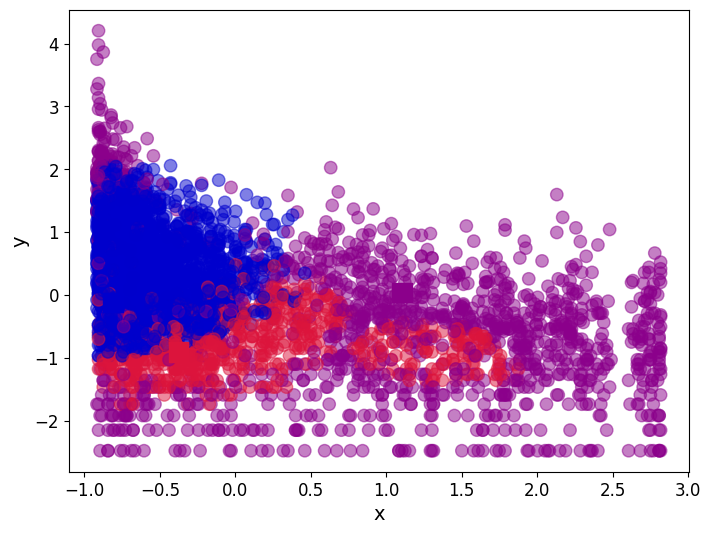

In [138]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o', 
            c=df['centroid'].astype('category'), 
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200, c=[0, 1, 2], 
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [139]:
print("The total error is {0:.2f}".format(df['error'].sum()))

The total error is 431136167477.32


In [140]:
colnames = ['Recency','Frequency','Monetary']

centroids = df.groupby('centroid').agg('mean').loc[:, colnames].reset_index(drop = True)
centroids

,Recency,Frequency,Monetary
0,0.147202,-0.772123,-0.435250
1,-0.590586,0.460561,0.294629
2,0.970745,-0.405440,-0.290760


In [128]:
def kmeans(dset, k=2, tol=1e-4):
    '''
    K-means implementationd for a 
    `dset`:  DataFrame with observations
    `k`: number of clusters, default k=2
    `tol`: tolerance=1E-4
    '''
    # Let us work in a copy, so we don't mess the original
    working_dset = dset.copy()
    # We define some variables to hold the error, the 
    # stopping signal and a counter for the iterations
    err = []
    goahead = True
    j = 0
    
    # Step 2: Initiate clusters by defining centroids 
    centroids = initiate_centroids(k, dset)

    while(goahead):
        # Step 3 and 4 - Assign centroids and calculate error
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids) 
        err.append(sum(j_err))
        
        # Step 5 - Update centroid position
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

        # Step 6 - Restart the iteration
        if j>0:
            # Is the error less than a tolerance (1E-4)
            if err[j-1]-err[j]<=tol:
                goahead = False
        j+=1

    working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
    return working_dset['centroid'], j_err, centroids

# df['centroid'], j_err, centroids = kmeans(df, k=2, tol=1e-4)

# print(df['centroid'], j_err, centroids)

0       1
1       1
2       1
3       1
4       1
       ..
4317    1
4318    1
4319    1
4320    1
4321    1
Name: centroid, Length: 4322, dtype: int64 [5.194558172991654e+35, 5.1963313879410126e+35, 5.196331320396643e+35, 5.196320417041315e+35, 5.196331168073127e+35, 5.1670849085315034e+35, 5.1963314179200295e+35, 5.1963313138928636e+35, 5.196329770417547e+35, 5.192532073536883e+35, 5.196331415733605e+35, 5.1679274495568654e+35, 5.196281581987601e+35, 5.1961097023590026e+35, 5.177140455211933e+35, 5.1963313987750946e+35, 5.1963313803483534e+35, 5.196330523792571e+35, 5.196326389625177e+35, 5.19565641012032e+35, 5.196331259093838e+35, 5.196331379185629e+35, 5.196310423140904e+35, 5.196331420030542e+35, 5.1963314167204015e+35, 5.196323629350885e+35, 5.194411444652362e+35, 5.1963314062488674e+35, 5.196319641616446e+35, 5.196331064857766e+35, 5.1963312915112556e+35, 5.1963314200033966e+35, 5.195928083363981e+35, 5.1963209953522284e+35, 5.196331411244056e+35, 5.196331403011417e+35, 5.1963

In [141]:
np.random.seed(42)
df['centroid'], df['error'], centroids =  kmeans(df[['Recency','Frequency','Monetary']], 3)
df.head()

,Recency,Frequency,Monetary,centroid,error
0,-0.896486,1.171002,1.431403,1,0.150120
1,-0.141341,-0.238345,0.739514,0,2.372511
2,-0.729905,0.439216,0.721853,1,0.119654
3,2.208266,-0.703370,-0.589281,2,0.132599
4,-0.543223,0.649584,0.620128,1,0.041103


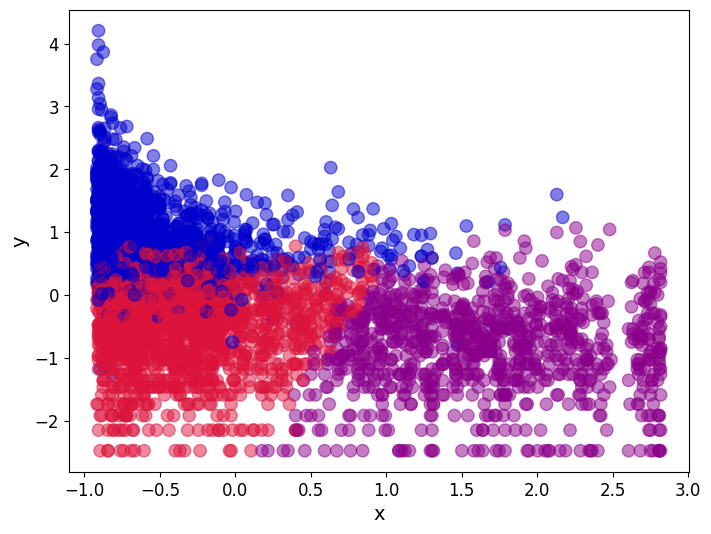

In [142]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o', 
            c=df['centroid'].astype('category'), 
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200, c=[0, 1, 2], 
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()